In [1]:
import os 
import torch
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm 

from torch.utils.data import Dataset, DataLoader

from transformers import BlipProcessor, BlipForQuestionAnswering

# Creating DF

In [2]:
IMAGE_FOLDER = "train_img"
LABEL_FILE = "label_train.txt"
with open(LABEL_FILE, 'r') as f:
    labels = [int(line.strip()) for line in f.readlines()]

# Get Paths
image_paths = [os.path.join(IMAGE_FOLDER, f"{i+1:06}.jpg") for i in range(len(labels))]
# Get Labels
labels = labels
# Join
df=pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})
df.head(3)

,image_path,label
0,train_img/000001.jpg,1
1,train_img/000002.jpg,1
2,train_img/000003.jpg,1


# Class Balance

<Axes: xlabel='label'>

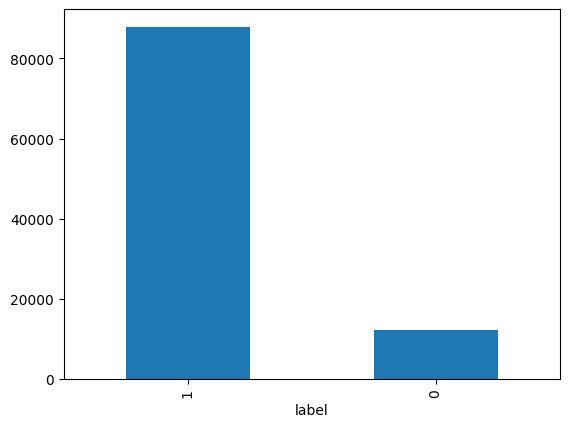

In [3]:
df.label.value_counts().plot(kind='bar')

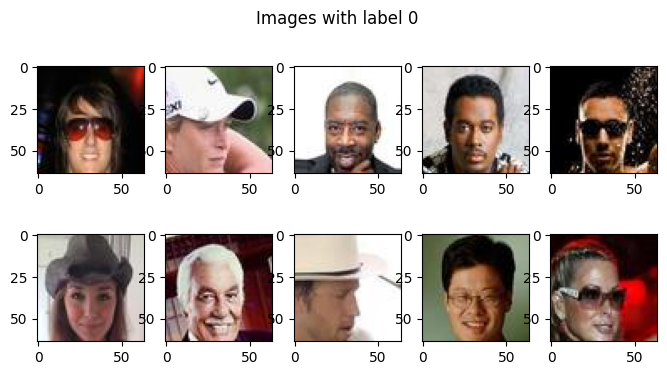

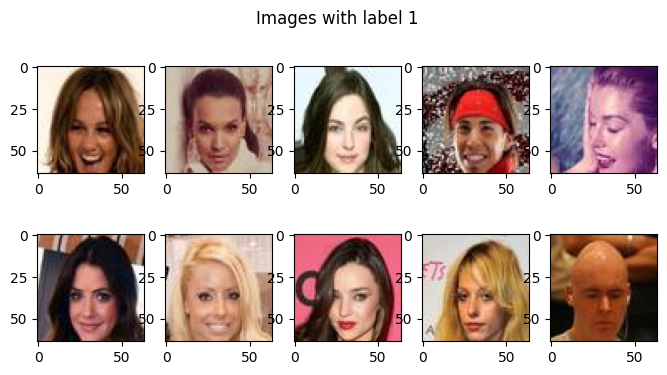

In [4]:
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
for i,path in enumerate(df[df.label==0].sample(10).image_path):
    img = Image.open(path)
    ax[i%2, i//2].imshow(img)
fig.suptitle("Images with label 0")
plt.show()
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
for i,path in enumerate(df[df.label==1].sample(10).image_path):
    img = Image.open(path)
    ax[ i%2,i//2].imshow(img)
fig.suptitle("Images with label 1")
plt.show()

In [5]:
# Define Dataset Class
original_df = df.copy()
df=df[df.label==0]

# Load VQA

In [6]:
# Load BLIP VQA model
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to("cuda" if torch.cuda.is_available() else "cpu")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# Label Data using Blip VQA

### Create VQA Dataset

In [7]:
# Fix tokenizer parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Sub Classes uestions
questions = [
    "Is the person wearing glasses?",
    "Is the person wearing a hat?", 
    "Does this person have facial hair?"
]

def optimized_collate_fn(batch):
    """Optimized collate function with better memory management"""
    # Pre-allocate lists
    input_batches = []
    image_paths = []
    
    for item in batch:
        input_batches.append(item["inputs"])
        image_paths.append(item["path"])
    
    # More efficient tensor concatenation
    batched_inputs = {}
    for key in input_batches[0].keys():
        tensors = [inp[key] for inp in input_batches]
        batched_inputs[key] = torch.cat(tensors, dim=0)
    
    return batched_inputs, image_paths

class VQADataset(Dataset):
    def __init__(self, image_paths, questions, processor):
        self.image_paths = image_paths
        self.questions = questions
        self.processor = processor
        self.images = {}
    
    def __len__(self):
        return len(self.image_paths)
    
    def _load_image(self, path):
        return Image.open(path).convert("RGB")
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = self._load_image(image_path)
        
        # Process all questions for this image at once
        inputs = self.processor(
            [image] * len(self.questions),
            self.questions,
            padding=True,
            return_tensors="pt"
        )
        return {"inputs": inputs, "path": image_path}

### Batch Process function

In [8]:
def process_vqa_batch(model, processor, df, questions, 
                     batch_size=16, num_workers=4,
                     mixed_precision=True):
    """
    VQA processing
    
    Args:
        model: VQA model
        processor: Image/text processor
        df: DataFrame with image_path column
        questions: List of questions to ask
        batch_size: Batch size (increased default)
        num_workers: Number of data loading workers
        preload_images: Whether to preload images in memory
        mixed_precision: Use automatic mixed precision
    """
    
    # Prepare dataset and dataloader
    image_paths = df["image_path"].tolist()
    dataset = VQADataset(image_paths, questions, processor)
    
    # Optimized DataLoader settings
    loader = DataLoader(
        dataset, 
        batch_size=batch_size,
        collate_fn=optimized_collate_fn,
        num_workers=num_workers, 
        pin_memory=True if torch.cuda.is_available() else False,
        prefetch_factor=None,  # Only works with num_workers > 0
        persistent_workers=False
    )
    
    # Initialize results storage
    all_answers = []

    # Move model to appropriate device
    model.eval()
    
    # Use automatic mixed precision if available and requested
    use_amp = mixed_precision and torch.cuda.is_available()
    if use_amp:
        try:
            # Try new format first (PyTorch 1.10+)
            autocast = lambda: torch.amp.autocast('cuda')
        except:
            # Fall back to old format
            autocast = torch.cuda.amp.autocast
    else:
        autocast = torch.no_grad  # Fallback to regular context
    
    with torch.no_grad():
        for batch_idx, (inputs, paths) in enumerate(tqdm(loader, desc="Processing VQA")):
            # Move inputs to device efficiently
            inputs = {k: v.to(model.device, non_blocking=True) for k, v in inputs.items()}
            
            with autocast():
                # Generate answers with optimized parameters
                # Remove pad_token_id to avoid conflict with model's internal settings
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=20,  # Reduced for yes/no questions
                    do_sample=False,    # Deterministic for consistency
                    num_beams=1,        # Greedy decoding for speed
                )
            
            # Decode answers
            answers = processor.batch_decode(outputs, skip_special_tokens=True)
            all_answers.extend(answers)
            
            # Clear GPU cache periodically (less frequent)
            if batch_idx % 20 == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    # Reshape answers into structured format more efficiently
    num_questions = len(questions)
    num_images = len(image_paths)
    
    # Pre-allocate list for better performance
    structured_answers = [None] * num_images
    
    for i in range(num_images):
        start_idx = i * num_questions
        image_answers = {
            questions[j]: all_answers[start_idx + j] 
            for j in range(num_questions)
        }
        structured_answers[i] = image_answers
    
    # Create result DataFrame
    result_df = pd.DataFrame({
        "image_path": image_paths,
        "answers": structured_answers
    })
    
    # Clean up
    del all_answers
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return result_df

### Inference

In [9]:
# Process with optimizations
result_df = process_vqa_batch(
    model=model,
    processor=processor, 
    df=df,
    questions=questions,
    batch_size=16,#optimal_batch_size,
    num_workers=0,  
    mixed_precision=True
)

print(result_df.head())

Processing VQA: 100%|██████████| 757/757 [18:35<00:00,  1.47s/it]

             image_path                                            answers
0  train_img/000037.jpg  {'Is the person wearing glasses?': 'no', 'Is t...
1  train_img/000053.jpg  {'Is the person wearing glasses?': 'yes', 'Is ...
2  train_img/000068.jpg  {'Is the person wearing glasses?': 'no', 'Is t...
3  train_img/000074.jpg  {'Is the person wearing glasses?': 'no', 'Is t...
4  train_img/000093.jpg  {'Is the person wearing glasses?': 'yes', 'Is ...


### Convert results to DataFrame

In [10]:
# Convert dict to DataFrame
answers_df = pd.DataFrame(result_df['answers'].tolist())
result_df = pd.concat([result_df[['image_path']], answers_df], axis=1)
    
# Combine with the image_path column
result_df.head(5)

,image_path,Is the person wearing glasses?,Is the person wearing a hat?,Does this person have facial hair?
0,train_img/000037.jpg,no,yes,yes
1,train_img/000053.jpg,yes,no,no
2,train_img/000068.jpg,no,yes,no
3,train_img/000074.jpg,no,yes,no
4,train_img/000093.jpg,yes,no,no


,image_path,Is the person wearing glasses?,Is the person wearing a hat?,Does this person have facial hair?
2767,train_img/023036.jpg,no,yes,no


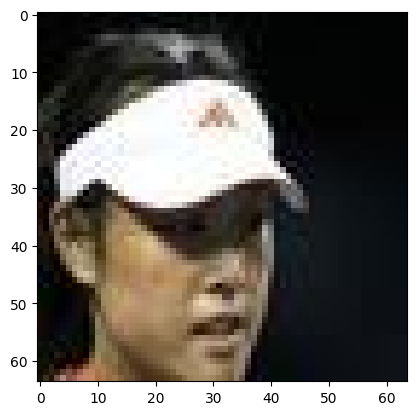

In [11]:
# Show an example image and its answers
example=result_df.sample(1)

display(example)
plt.imshow(Image.open(example.image_path.values[0]))
plt.show()

In [12]:
for column in result_df.columns[1:]:
    print('------------------------------------')
    print(result_df[column].value_counts())

------------------------------------
Is the person wearing glasses?
yes    6288
no     5814
Name: count, dtype: int64
------------------------------------
Is the person wearing a hat?
no     8082
yes    4020
Name: count, dtype: int64
------------------------------------
Does this person have facial hair?
no     6273
yes    5829
Name: count, dtype: int64


### Convert Answers to Binary

In [13]:
# convert columns from yes/no to 0/1
for column in result_df.columns[1:]:
    result_df[column] = result_df[column].apply(lambda x: 1 if x.lower() == 'yes' else 0)
result_df.head(5)

,image_path,Is the person wearing glasses?,Is the person wearing a hat?,Does this person have facial hair?
0,train_img/000037.jpg,0,1,1
1,train_img/000053.jpg,1,0,0
2,train_img/000068.jpg,0,1,0
3,train_img/000074.jpg,0,1,0
4,train_img/000093.jpg,1,0,0


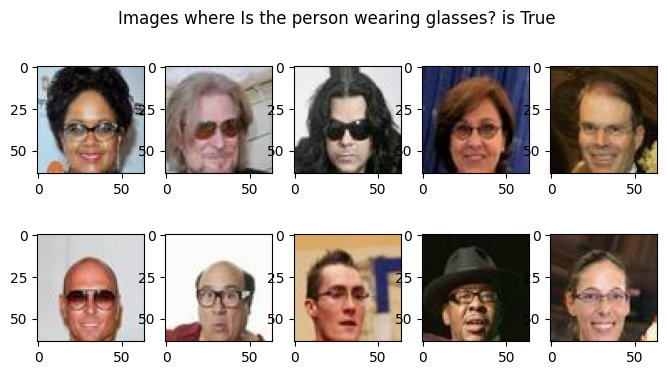

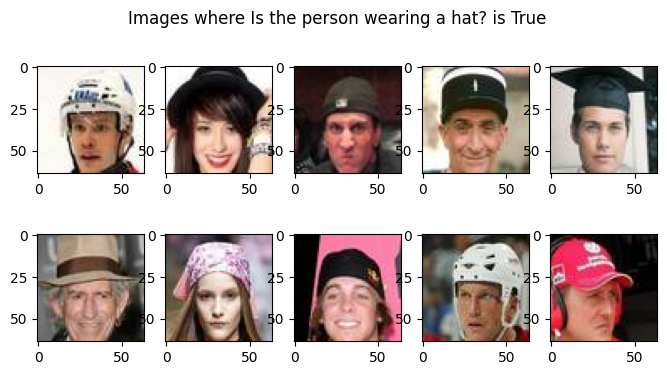

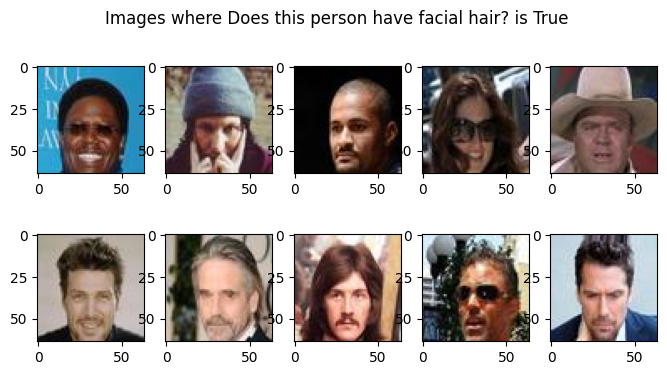

In [15]:
def show_columns(df,name):
    fig, ax = plt.subplots(2, 5, figsize=(8, 4))
    for i,path in enumerate(df[df[name]==1].sample(10).image_path):
        img = Image.open(path)
        ax[i%2, i//2].imshow(img)
    plt.suptitle(f"Images where {name} is True")
    plt.show()
for column in result_df.columns[1:]:
    show_columns(result_df, column)

In [16]:
# Rename  Columns
result_df.rename(columns={
    'Is the person wearing glasses?': 'glasses',
    'Is the person wearing a hat?': 'hat',
    'Does this person have facial hair?': 'facial_hair'
}, inplace=True)
result_df.head(2)

,image_path,glasses,hat,facial_hair
0,train_img/000037.jpg,0,1,1
1,train_img/000053.jpg,1,0,0


In [17]:
# Add empty answers to the fulldf 
df=pd.concat([result_df,original_df[original_df.label==1]])

# setlabels from nan to 1
for column in df.columns[1:]:
    df[column] = df[column].apply(lambda x: 0 if pd.isna(x) else x)
df.head(5)

,image_path,glasses,hat,facial_hair,label
0,train_img/000037.jpg,0.0,1.0,1.0,0.0
1,train_img/000053.jpg,1.0,0.0,0.0,0.0
2,train_img/000068.jpg,0.0,1.0,0.0,0.0
3,train_img/000074.jpg,0.0,1.0,0.0,0.0
4,train_img/000093.jpg,1.0,0.0,0.0,0.0


In [18]:
df.to_csv('labeled_data.csv')